In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import store_bin, project_dir, data_files, load_csv, load_bin, write_xlsx
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import collect, value, flatten, normalize_rows
from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data

In [2]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_struct = (
        load_bin("ax_var_struct.feather")
        .sort_values(["Variable", "Label"])
        .reset_index(drop=True)
    )

2019-10-16 13:06:00 [INFO] Started loading binary file
2019-10-16 13:06:00 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
2019-10-16 13:06:00 [INFO] Finished loading binary file in 0.16s (0.55s CPU)
2019-10-16 13:06:00 [INFO] Started loading binary file
2019-10-16 13:06:00 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_struct.feather
2019-10-16 13:06:00 [INFO] Finished loading binary file in 0.0s (0.0s CPU)


In [3]:
Variable = namedtuple("Variable", ["Label", "Codes"])

var_info = {}
for var, data in ax_var_struct.groupby("Variable"):
    var_info[var] = Variable(data["Variable_Label"].max(), data["Label"].to_list())

## Define code order, where necessary

In [4]:
var_codes_ordered = {
    "md_agenatrep": {
        "14-29 Jahre": 1,
        "30-45 Jahre": 2,
        "46-60 Jahre": 3,
        "61+ Jahre": 4,
    },
    "md_bildung3": {
        "niedrig (kein Abschluss, obligat. Schule, HH-Lehrjahr, Handelsschule, Anlehre)": 1,
        "mittel (Diplommittelschule, allg. Schule, Berufslehre, Vollzeitberufsschule, Maturität, Lehrerseminar)": 2,
        "hoch (Universität, ETH, FH, PH, höhere Berufsausbildung)": 3,
    },
    "md_hhgr3": {"1 Person": 1, "2 Personen": 2, "3+ Personen": 3},
    "g_privatetrainuse": {
        "Nie": 1,
        "1-2 Mal jährlich": 2,
        "3-12 Mal jährlich": 3,
        "2-5 Mal pro Monat": 4,
        "6 Mal pro Monat oder häufiger": 5,
    },
    "md_203": {  # Bahnnutzung beruflich
        "Nie": 1,
        "Seltener": 2,
        "Etwa zu einem Viertel": 3,
        "Etwa zur Hälfte": 4,
        "Meistens": 5,
        "Immer": 6,
    },
    "g_220": {  # Autos im Haushalt
        "Keines": 1,
        "1 Auto": 2,
        "2+ Autos": 3,
    },
    "md_410": {  # Internetnutzung
        "seltener": 1,
        "mehrmals pro Monat": 2,
        "einmal pro Woche": 3,
        "mehrmals pro Woche": 4,
        "täglich/fast täglich": 5,
    },
    # Div.Internet-Nutzungsarten (md_421 bis md_411)
    "md_421": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_419": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_417": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_416": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_415": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_414": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_413": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_412": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_411": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_early": {
        "Ich bin immer einer/eine der ersten, der/die neue Technologien und Geräte kauft resp. einsetzt.": 1,
        "Ich fange erst dann an, neue Technologien und Geräte zu verwenden, wenn ich weiss, welche Erfahrungen andere mit ihnen gemacht haben.": 2,
        "Ich übernehme neue Technologien und Geräte erst dann, wenn es für mich persönlich oder beruflich unerlässlich ist.": 3,
    },
    "md_tv": {"kein TV-Gerät": 1, "1 oder mehrere TV-Geräte": 2},
    "g_TvChannelsgroup": {
        "keine Sender": 1,
        "1-4 Sender": 2,
        "5-9 Sender": 3,
        "10++ Sender": 4,
    },
    "g_flug": {"keine Flüge": 1, "1 - 4 Flüge": 2, "5 - 9 Flüge": 3, "10++ Flüge": 4},
    "g_flugBusiness": {
        "keine Flüge": 1,
        "1 - 4 Flüge": 2,
        "5 - 9 Flüge": 3,
        "10++ Flüge": 4,
    },
    "md_ek": {
        "Keine Angabe": 0,
        "Weniger als 3'000 CHF": 1,
        "Zwischen 3'000 und 4'500 CHF": 2,
        "Zwischen 4'501 und 6'000 CHF": 3,
        "Zwischen 6'001 und 9'000 CHF": 4,
        "Zwischen 9'001 und 12'000 CHF": 5,
        "Mehr als 12'000 CHF": 6,
    },
    "md_hhverm": {
        "Keine Angabe": 0,
        "Weniger als CHF 50 000": 1,
        "Zwischen CHF 50 000 und CHF 100 000": 2,
        "Zwischen CHF 100 000 und CHF 250 000": 3,
        "Zwischen CHF 250 000 und CHF 500 000": 4,
        "Zwischen CHF 500 000 und CHF 1 Mio.": 5,
        "Zwischen CHF 1 Mio. und CHF 5 Mio.": 6,
        "Mehr als CHF 5 Mio.": 7,
    },
}

### Write ordered codes into var_info

In [5]:
for ordered_var, codes in var_codes_ordered.items():
    var_info[ordered_var] = Variable(var_info[ordered_var].Label, list(codes))

### Variable/Code table for output

In [6]:
var_info_tab = pd.DataFrame.from_records(
    columns=["Variable", "Label", "Codes"],
    data=[
        (var, var_info[var].Label, ",".join(var_info[var].Codes)) for var in var_info
    ],
    index="Variable",
)

In [8]:
with project_dir("axinova"):
    write_xlsx(var_info_tab, "variable_info.xlsx", sheet_name="Variables")

2019-10-16 13:06:30 [INFO] Started writing xlsx file
2019-10-16 13:06:30 [INFO] Writing to file C:\Users\kpf\data\axinova\variable_info.xlsx
2019-10-16 13:06:30 [INFO] Written 10.6 KB
2019-10-16 13:06:30 [INFO] Finished writing xlsx file in 0.05s (0.03s CPU)


In [9]:
def var_label(variable):
    return var_info[variable].Label


def var_codes(variable):
    return var_info[variable].Codes

In [10]:
weekday_order = ax_data["DayOfWeek"].cat.categories.to_list()
timeSlot_order = ax_data["TimeSlot"].cat.categories.to_list()

with value(ax_data["DayOfWeek"].isin(["Saturday", "Sunday"])) as weekend_rows:
    ax_data_weekends = ax_data.loc[weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)
    ax_data_workdays = ax_data.loc[~weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)

In [11]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/7739206,27,7.4 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/7739206,7,7.4 MB,"[Monday,Sunday]"
Time,category,0/7739206,96,7.4 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/7739206,117,7.4 MB,"[g_220,nat_ausland]"
Code,category,0/7739206,156,14.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/7739206,423653,59.0 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/7739206,1,7.4 MB,"[2019,2019]"
Month,category,0/7739206,5,7.4 MB,"[05,09]"
logValue,float64,0/7739206,423653,59.0 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,213682/7525524,114,7.4 MB,"[nan,kein Mobiltelefon]"


In [12]:
desc_col(ax_data_workdays, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/5652746,27,5.4 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/5652746,5,5.4 MB,"[Monday,Friday]"
Time,category,0/5652746,96,5.4 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/5652746,117,5.4 MB,"[g_220,nat_ausland]"
Code,category,0/5652746,155,10.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/5652746,359475,43.1 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/5652746,1,5.4 MB,"[2019,2019]"
Month,category,0/5652746,5,5.4 MB,"[05,09]"
logValue,float64,0/5652746,359475,43.1 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,155587/5497159,114,5.4 MB,"[nan,kein Mobiltelefon]"


In [13]:
desc_col(ax_data_weekends, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/2086460,27,2.0 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/2086460,2,2.0 MB,"[Saturday,Sunday]"
Time,category,0/2086460,96,2.0 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/2086460,117,2.0 MB,"[g_220,nat_ausland]"
Code,category,0/2086460,155,4.0 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/2086460,93565,15.9 MB,"[0.47903999999999997,30.32099024]"
Year,category,0/2086460,1,2.0 MB,"[2019,2019]"
Month,category,0/2086460,5,2.0 MB,"[05,09]"
logValue,float64,0/2086460,93565,15.9 MB,"[-0.7359711777508736,3.4118402198714635]"
VarDesc,category,58095/2028365,114,2.0 MB,"[nan,kein Mobiltelefon]"


# Check distributions

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Time

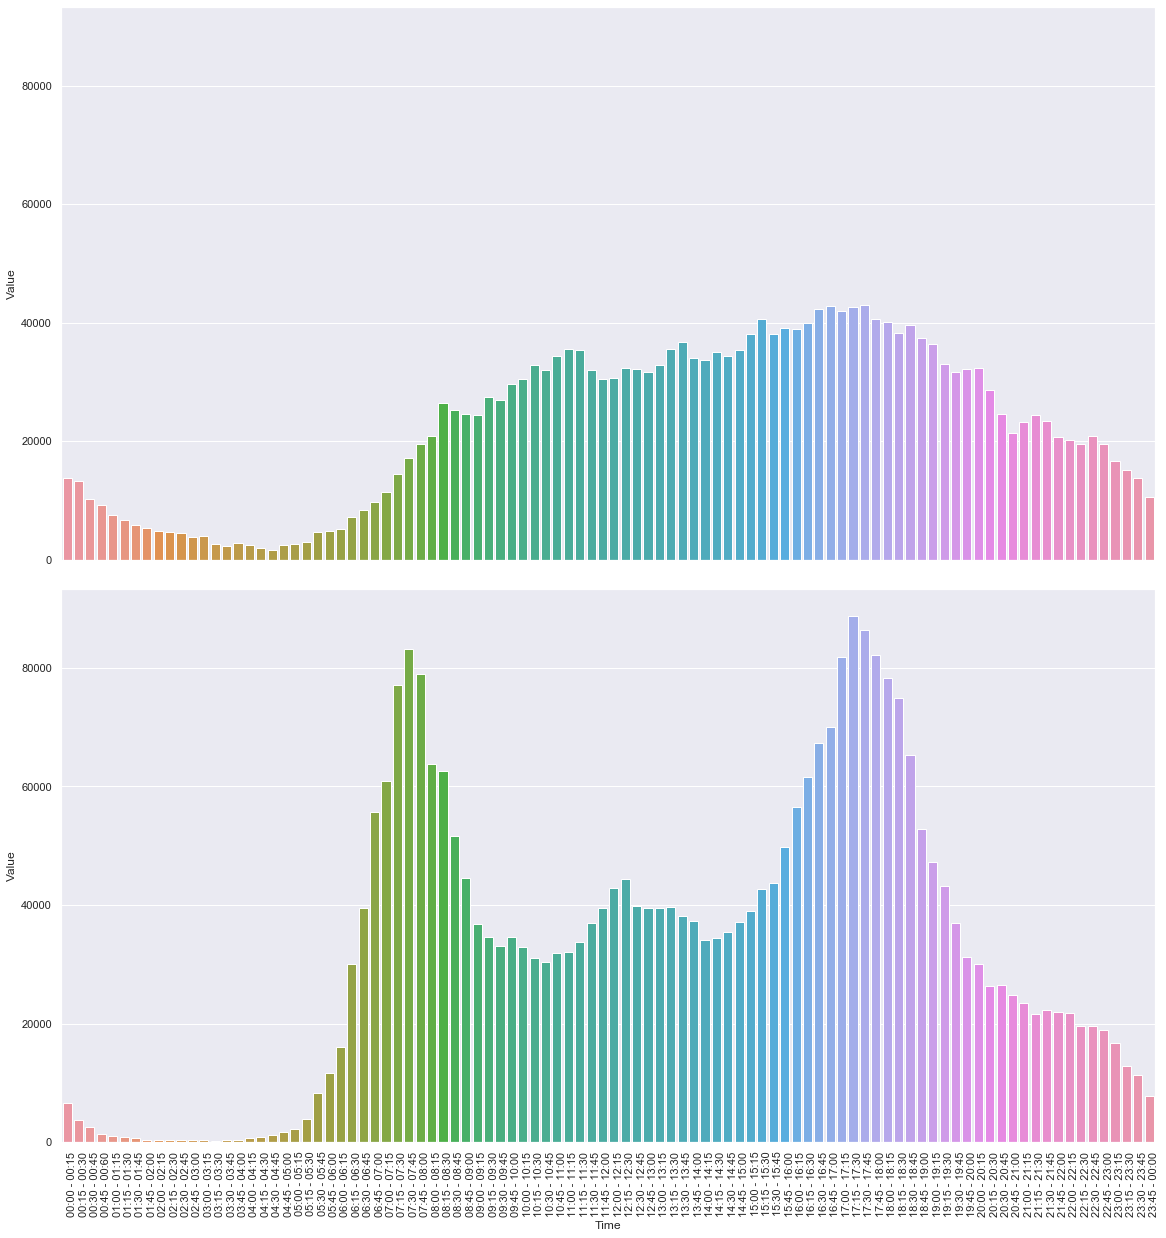

In [15]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"), # average workday
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"), # average weekend day
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_weekend,
)
fig.autofmt_xdate(rotation=90, ha="left")

### Time by Weekday

In [ ]:
sns.catplot(
    data=ax_data,
    kind="bar",
    x="Time",
    y="Value",
    row="DayOfWeek",
    row_order=weekday_order,
    ci=None,
    estimator=np.sum,
    height=6,
    aspect=2,
)

## Hours

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),  # average workday
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),  # average weekend day
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)

## Time Slots

In [ ]:
ax_data["TimeSlot"].value_counts()

### Plot sum(value) per time slot, scaled to one day

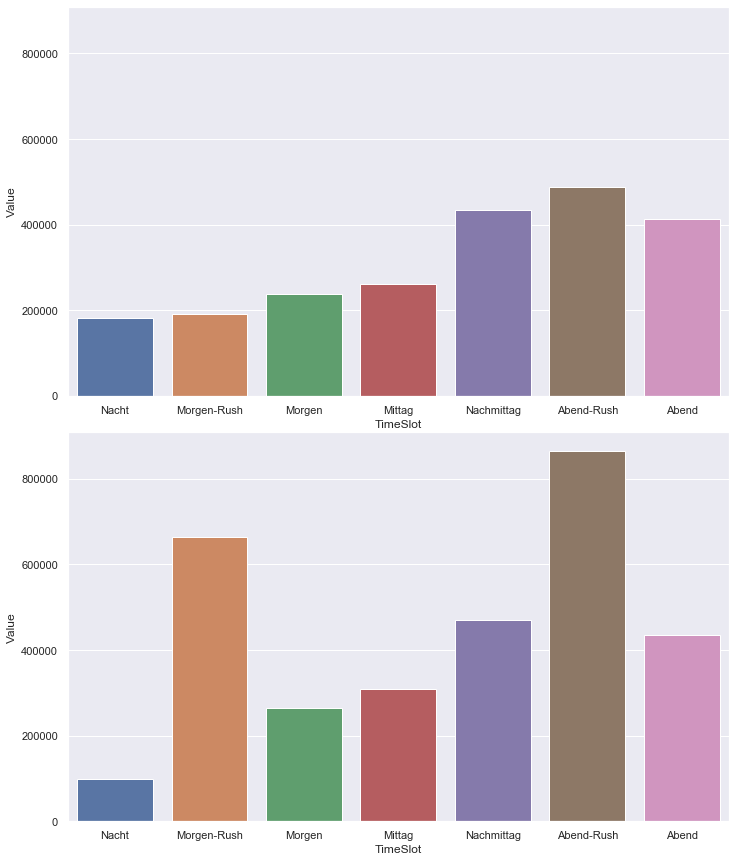

In [16]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(10, 12)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)

## Stations

In [ ]:
ax_data.Station.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Station", y="Value", ci=None, estimator=np.sum)

## Weekdays

In [ ]:
ax_data.DayOfWeek.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="DayOfWeek",
    y="Value",
    ci="sd",
    estimator=np.sum,
    order=weekday_order,
)

## Months

In [ ]:
ax_data.Month.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="Month",
    y="Value",
    estimator=np.sum,
    ci=None
);

## Variables (Questions)

In [ ]:
ax_data.Variable.value_counts()

In [ ]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

sns.barplot(
    data=ax_data,
    x="Variable",
    y="Value",
    estimator=np.sum,
    ci=None,
);

# Tests for Independence

In [ ]:
from scipy.stats import chi2_contingency


def _var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result


def factor_dependance(data, factor, partitions):
    all_var_assoc = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for v in var_info.keys():
        var_assoc = _var_factor_dependance(
            data=data, variable=v, factor=factor, partitions=partitions
        ).query(f"p_{factor} <= 0.05")
        all_var_assoc = all_var_assoc.append(var_assoc, ignore_index=True, sort=False)
    all_var_assoc["VarDesc"] = all_var_assoc["Var"].apply(var_label)
    return all_var_assoc

## For all variables, find stations where the distribution of codes is dependent on day time / time slot

In [ ]:
%%time
# around 1.5 minutes
all_var_assoc_time = factor_dependance(
    data=ax_data, factor="Time", partitions=["Station"]
)
all_var_assoc_timeslot = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station"]
)

In [ ]:
var_stations_time = pd.crosstab(
    index=all_var_assoc_time["VarDesc"].str.cat(all_var_assoc_time["Var"], sep=" [")
    + "]",
    columns=all_var_assoc_time["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_time, "var_by_station_vs_time.xlsx", sheet_name="contigency tab"
    )

In [ ]:
var_stations_timeslot = pd.crosstab(
    index=all_var_assoc_timeslot["VarDesc"].str.cat(
        all_var_assoc_timeslot["Var"], sep=" ["
    ) + ']',
    columns=all_var_assoc_timeslot["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_timeslot,
        "var_by_station_vs_timeslot.xlsx",
        sheet_name="contigency tab",
    )

### Which variables have the most stations where their codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Var", as_index=False).agg(
    {"VarDesc": "max", "Label": ["count", collect]}
).set_axis(
    ["Variable", "VarDesc", "#", "Stations"], axis="columns", inplace=False
).sort_values(
    "#", ascending=False
).set_index(
    "Variable"
)

### Which stations have the most variables whose codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Label", as_index=False).agg(
    {"Var": ["size", collect]}
).set_axis(["Station", "#", "Variables"], axis="columns", inplace=False).sort_values(
    "#", ascending=False
).set_index(
    "Station"
)

## For a single variable, show distribution of codes over time

In [17]:
import altair as alt

alt.data_transformers.enable("default", max_rows=None)

time_order = {"DayOfWeek": weekday_order, "TimeSlot": timeSlot_order}

def plot_var_time_dist(data, variable, over, station, as_percent=False):
    subset = (
        data.query("Station == @station and Variable == @variable")
        .pipe(clean_up_categoricals)
        .copy()
    )
    codes_sorted = variable in var_codes_ordered
    if codes_sorted:
        subset["Code_order"] = subset["Code"].replace(var_codes_ordered[variable])
        code_list_sorted = var_info[variable].Codes
    chart = (
        alt.Chart(subset)
        .mark_bar()
        .encode(
            x=alt.X("sum(Value)", stack="normalize") if as_percent else "sum(Value)",
            y=alt.Y(
                over,
                sort=time_order.get(over, "ascending"),
            ),
            color=alt.Color(
                "Code",
                sort=code_list_sorted if codes_sorted else "ascending",
                scale=alt.Scale(scheme="spectral" if codes_sorted else "category20"),
            ),
            order=alt.Order("Code_order") if codes_sorted else alt.Order("Code"),
        )
        .configure_view(width=800)
        .properties(
            title=f"{var_label(variable)} | {over} [{station}]"
            + (", Prozent" if as_percent else "")
        )
    )
    return chart

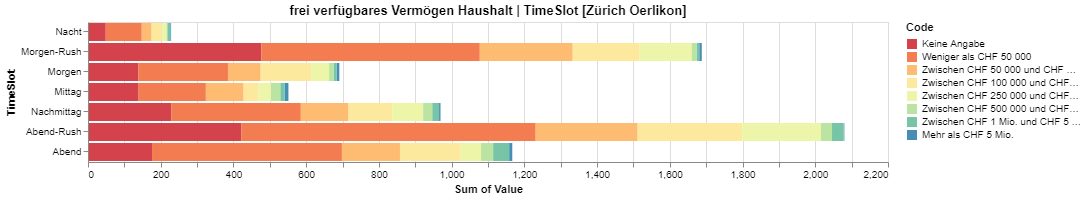

In [19]:
plot_var_time_dist(
    data=ax_data_workdays,
    variable='md_hhverm',
    over="TimeSlot",
    station="Zürich Oerlikon",
    as_percent=False,
)

## Does time-dependance of variables change between months?

In [ ]:
%%time
all_var_assoc_timeslot_month = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station", "Month"]
)

In [ ]:
pd.crosstab(
    index=all_var_assoc_timeslot_month["Var"],
    columns=all_var_assoc_timeslot_month["Label"],
)

# ANOVA

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [ ]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov["mean_sq"] = aov[:]["sum_sq"] / aov[:]["df"]
    aov["eta_sq"] = aov[:-1]["sum_sq"] / sum(aov["sum_sq"])
    aov["omega_sq"] = (aov[:-1]["sum_sq"] - (aov[:-1]["df"] * aov["mean_sq"][-1])) / (
        sum(aov["sum_sq"]) + aov["mean_sq"][-1]
    )
    cols = ["sum_sq", "df", "mean_sq", "F", "PR(>F)", "eta_sq", "omega_sq"]
    aov = aov[cols]
    return aov


def calc_anova(data, variable, formula="logValue ~ Code + Station + DayOfWeek"):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    subset = subset.assign(
        label=subset.Station.str.cat([subset.DayOfWeek.str[:3], subset.Code], sep="|")
    )
    subset.set_index("label", inplace=True)
    mod = smf.ols(formula=formula, data=subset)
    res = mod.fit()
    print(f"Variable: {var_label(variable)}")
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())


def anova_stats(data, variable):
    """ANOVA statistics"""
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)

    lm_base = smf.ols(formula="logValue ~ Code:TimeSlot:DayOfWeek", data=subset).fit()
    lm_base_station = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station", data=subset
    ).fit()
    lm_base_station_month = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station + Month", data=subset
    ).fit()
    return {
        "var": variable,
        "base": lm_base.rsquared,
        "base+station": lm_base_station.rsquared,
        "base+station+month": lm_base_station_month.rsquared,
    }

In [ ]:
calc_anova(ax_data_workdays, var.g_220, formula='logValue ~ Code:TimeSlot:DayOfWeek + Station + Month')

In [ ]:
%%time
all_var_stats = pd.DataFrame.from_records(
    columns="var base base+station base+station+month".split(),
    data=[anova_stats(ax_data_workdays, v) for v in var.keys()],
    index="var",
)

all_var_stats = all_var_stats.assign(
    **{
        "plus_station": all_var_stats["base+station"] - all_var_stats["base"],
        "plus_month": all_var_stats["base+station+month"]
        - all_var_stats["base+station"],
        "plus_station_month": all_var_stats["base+station+month"]
        - all_var_stats["base"],
    }
)

In [ ]:
all_var_stats.sort_values("base+station+month", ascending=False).loc[
    :, "base plus_station plus_month base+station+month".split()
]

# Estimation and Confidence Intervals for Target Groups

## Select data by any column(s)

In [20]:
def _check_selection(data, selection, select_columns):
    values = {}
    for column in select_columns:
        values[column] = data[column].cat.categories
    if set(selection.keys()) - set(select_columns) != set():
        raise NameError(f"Unknown column name in selection: {selection.keys()}")
    clean_sel = {}
    for col in select_columns:
        if col in selection:
            col_values = list(flatten(selection[col]))
            if set(col_values) - set(values[col]) != set():
                raise ValueError(f"Illegal value(s) in parameter {col}: {col_values}")
            clean_sel[col] = col_values
        else:
            clean_sel[col] = None
    return clean_sel


def select_data(all_data, **selection):
    select_columns = "DayOfWeek Station Variable Month TimeSlot Hour Time".split()
    selection = _check_selection(all_data, selection, select_columns)
    row_mask = pd.Series([True] * all_data.shape[0])
    for col in select_columns:
        if selection[col] is not None:
            row_mask &= all_data[col].isin(selection[col])
    return all_data.loc[row_mask].pipe(clean_up_categoricals)

## Display selection as pivot table (Codes vs. Time)

In [38]:
def code_tables(selection, index_by, aggfunc="sum"):
    data = select_data(ax_data, **selection)
    for var, subset in data.groupby("Variable"):
        prop_table = subset.pivot_table(
            index=index_by,
            columns="Code",
            values="Value",
            aggfunc=aggfunc,
            margins=False,
            fill_value=0,
        ).loc[:, var_codes(var)]
        print(f"Variable: {var_label(var)} ({var})")
        print(
            "Selection: "
            + ", ".join(f"{col} = {values}" for col, values in selection.items())
        )
        display(prop_table)
        if aggfunc in ("sum", np.sum):
            print("Code percentages:")
            display(normalize_rows(prop_table).round(3) * 100)

## Calculate code proportions

In [39]:
selection = dict(
    # DayOfWeek=["Saturday", "Sunday"],
    # Station="Basel SBB",
    Variable=["md_817"]
)

code_tables(selection, index_by=["Month"])

Variable: Sport: Schneesport (md_817)
Selection: Variable = ['md_817']


Code,not quoted,quoted
Month,,
05,16956.034719,7826.758294
06,15109.745644,7093.273416
07,14848.032804,6533.775609
08,14669.398374,7416.137418
09,15233.012762,7054.837258


Code percentages:


Code,not quoted,quoted
Month,,
05,68.4,31.6
06,68.1,31.9
07,69.4,30.6
08,66.4,33.6
09,68.3,31.7


## Estimate cell median and confidence intervals (quantiles)

In [25]:
def estimate(s):
    try:
        return np.percentile(s, [25, 50, 75]).tolist()
    except:
        return -1

In [26]:
selection = dict(
    #DayOfWeek=["Saturday", "Sunday"],
    Variable=["g_220"],
    #Station=["Basel SBB", "Zürich HB"],
)

code_tables(selection, index_by="TimeSlot", aggfunc=estimate)

Variable: Anzahl Autos im Haushalt (g_220)
Selection: Variable: ['g_220']


Code,Keines,1 Auto,2+ Autos
TimeSlot,,,
Nacht,"[0.9227944440000001, 1.066827273, 1.573772973]","[0.8900974359999999, 1.03611375, 1.518105164]","[0.905595833, 1.103194595, 1.5171]"
Morgen-Rush,"[0.9751662889999999, 1.682057142, 2.91224322725]","[1.03611375, 2.0146556230000003, 3.81774361]","[0.9798396229999999, 1.737259259, 3.061667627]"
Morgen,"[0.944775, 1.351795975, 2.286391993]","[0.943803279, 1.6354, 2.564144932]","[0.9162, 1.1871191490000002, 2.12774608]"
Mittag,"[0.9371363640000001, 1.423234783, 2.448104014]","[0.9429714290000001, 1.684935064, 2.76997119525]","[0.9227944440000001, 1.305821739, 2.310759626]"
Nachmittag,"[0.9544509090000001, 1.460231579, 2.438486746]","[0.959182222, 1.7116, 2.8264234175]","[0.9227944440000001, 1.295242553, 2.296075501]"
Abend-Rush,"[1.043227273, 1.864778055, 3.1664231220000003]","[1.0780358970000001, 2.177839091, 4.165210394]","[1.011073585, 1.7830933340000001, 3.010951245]"
Abend,"[0.951608696, 1.295242553, 2.222566666]","[0.9296413040000001, 1.305311111, 2.465235088]","[0.919454545, 1.1661, 2.0263686869999997]"
